# correlation function calculation
Qingyang Li, 2026.01.04

In this notebook, I show the calucaltion of correlation function in simulation box and mock groups.  
I will consider several ways to calculate correlation functions, including using CAMB, Nbodykit, and LS formula with support of Corrfunc.  
First, We begin from simulation box using Jiutian simulation.

In [2]:
from Corrfunc.theory.DD import DD
from Corrfunc.utils import convert_3d_counts_to_cf
from Corrfunc.theory.wp import wp
from Corrfunc.theory.xi import xi

## Simulation-DM

### load data

In [4]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [28]:
spnum = '127'
dsp = h5py.File("/home/cossim/qyli/Jiutian/M1000/snapshot/sample_M1000_snapshot%s_POS_rd0.01.hdf5"%spnum, 'r')
ptpos = dsp['POS'][:]
print("number of particles is ", len(ptpos))
np.random.seed(133)
rdpt = np.random.choice(range(len(ptpos)), size = int(len(ptpos)*0.01), replace = False)
ptpos = ptpos[rdpt]
print("number of particles is ", len(ptpos)) 

number of particles is  2319279806
number of particles is  23192798


### $\xi$(r)

#### From Corrfunc

In [9]:
def r_corrfunc_calculation(bins, X, Y, Z, rand_X, rand_Y, rand_Z, nthreads=None):
    if nthreads is None:
        nthreads = os.cpu_count()
    
    N = len(X)
    rand_N = len(rand_X)

    # DD
    DD_counts = DD(1, nthreads, bins, X, Y, Z, periodic = False, verbose = True)

    # DR
    DR_counts = DD(0, nthreads, bins, X, Y, Z,
                   X2=rand_X, Y2=rand_Y, Z2=rand_Z, periodic = False, verbose = True)
    # RR
    RR_counts = DD(1, nthreads, bins, rand_X, rand_Y, rand_Z,
                   periodic = False, verbose = True)

    cf = convert_3d_counts_to_cf(
        N, N, rand_N, rand_N,
        DD_counts, DR_counts,
        DR_counts, RR_counts
    )
    return cf

In [41]:
#generate a random catalog
boxsize = 1000
xx = ptpos[:,0]
yy = ptpos[:,1]
zz = ptpos[:,2]

rand_N = len(ptpos)*2
rand_X = np.random.uniform(0, boxsize, rand_N).astype('float32')
rand_Y = np.random.uniform(0, boxsize, rand_N).astype('float32')
rand_Z = np.random.uniform(0, boxsize, rand_N).astype('float32')

In [11]:
#run
nbins = 20
bins = np.logspace(-1, 1, nbins + 1) # note that +1 to nbins
cf = r_corrfunc_calculation(bins, xx, yy, zz, rand_X, rand_Y, rand_Z, nthreads = 18)
rx = (bins[1:] + bins[:-1])/2 
cfdata = np.c_[rx, cf] #1.rx; 2.corrfunc value

Running with points in [xmin,xmax] = 0.000000,999.999939 (non-periodic)
Running with points in [ymin,ymax] = 0.000000,999.999939 (non-periodic)
Running with points in [zmin,zmax] = 0.000000,999.999939 (non-periodic)
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 100,100,99.  Time taken =  13.424 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =    84 secs
ND1 =     23192798 [xmin,ymin,zmin] = [0.000000,0.000000,0.000000], [xmax,ymax,zmax] = [999.999939,999.999939,999.999939]
ND2 =     46385596 [xmin,ymin,zmin] = [0.000000,0.000000,0.000000], [xmax,ymax,zmax] = [1000.000000,1000.000000,999.999939]
Running with points in [xmin,xmax] = 0.000000,1000.000000 (non-periodic)
Running with points in [ymin,ymax] = 0.000000,1000.000000 (non-periodic)
Running with points in [zmin,zmax] = 0.000000,999.999939 (non-periodic)
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 10

In [67]:
#here direcly using corrfunc to calculate
nthreads = 18
results_xi = xi(boxsize, nthreads, bins, xx, yy, zz)

Text(0, 0.5, '$\\xi(r)$')

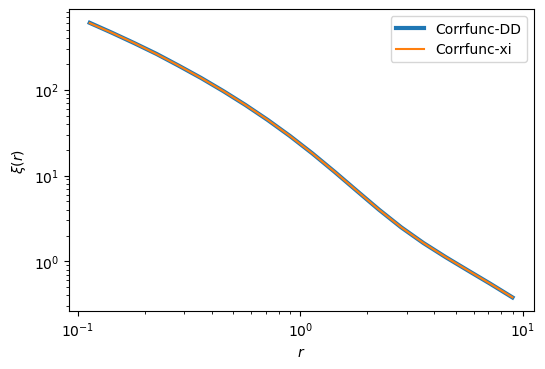

In [21]:
plt.figure(dpi = 100)
plt.plot(rx, cf, lw = 3, label = 'Corrfunc-DD')
plt.plot(rx, results_xi['xi'], label = 'Corrfunc-xi', zorder = 100)

plt.legend()
plt.loglog()
plt.xlabel(r'$r$')
plt.ylabel(r'$\xi(r)$')

Now, we use Corrfunc to calculate the pairs, and we compute correlation function by ourselves.

Note: if we compute the correlation function by ourselves, we need to increase the number of random sample. And the function from xi does not use this

In [45]:
xx, yy, zz = ptpos[:,0], ptpos[:,1], ptpos[:,2] 

rand_N = len(ptpos)*2
rand_X = np.random.uniform(0, boxsize, rand_N).astype('float32')
rand_Y = np.random.uniform(0, boxsize, rand_N).astype('float32')
rand_Z = np.random.uniform(0, boxsize, rand_N).astype('float32')

# DD
nbins = 20
bins = np.logspace(-1, 1, nbins + 1) # note that +1 to nbins

DD_counts = DD(1, 48, bins, xx, yy, zz, periodic = False, verbose = True)

# DR
DR_counts = DD(0, 48, bins, xx, yy, zz,
               X2=rand_X, Y2=rand_Y, Z2=rand_Z, periodic = False, verbose = True)

# RR
RR_counts = DD(1, 48, bins, rand_X, rand_Y, rand_Z,
               periodic = False, verbose = True)

Running with points in [xmin,xmax] = 0.000000,999.999939 (non-periodic)
Running with points in [ymin,ymax] = 0.000000,999.999939 (non-periodic)
Running with points in [zmin,zmax] = 0.000000,999.999939 (non-periodic)
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 100,100,99.  Time taken =  19.323 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =    82 secs
ND1 =     23192798 [xmin,ymin,zmin] = [0.000000,0.000000,0.000000], [xmax,ymax,zmax] = [999.999939,999.999939,999.999939]
ND2 =     46385596 [xmin,ymin,zmin] = [0.000000,0.000000,0.000000], [xmax,ymax,zmax] = [1000.000000,1000.000000,1000.000000]
Running with points in [xmin,xmax] = 0.000000,1000.000000 (non-periodic)
Running with points in [ymin,ymax] = 0.000000,1000.000000 (non-periodic)
Running with points in [zmin,zmax] = 0.000000,1000.000000 (non-periodic)
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 

23192798 46385596


Text(0, 0.5, '$\\xi(r)$')

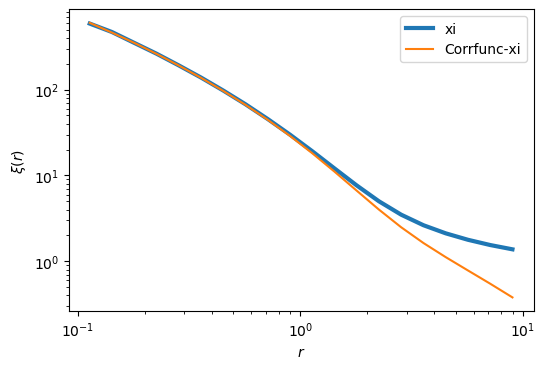

In [46]:
N = len(xx)
rand_N = len(rand_X)
print(N, rand_N)

DD_v = DD_counts['npairs'] / (N*(N-1)/2) 
DR_v = DR_counts['npairs'] / (N*rand_N) 
RR_v = RR_counts['npairs'] / (rand_N*(rand_N-1)/2)
xi_v = (DD_v - 2*DR_v + RR_v)/RR_v

rx = (bins[1:] + bins[:-1])/2 
plt.figure(dpi = 100)
plt.plot(rx, xi_v, lw = 3, label = 'xi')

plt.plot(rx, results_xi['xi'], label = 'Corrfunc-xi', zorder = 100)

plt.legend()
plt.loglog()
plt.xlabel(r'$r$')
plt.ylabel(r'$\xi(r)$')

#### From CAMB

Note CAMB usually used to compute power spectrum rather than correlation function. We need to integrate it by ourselves.

In [60]:
def xi_from_camb():
    import camb
    import numpy as np
    from mcfit import P2xi
    
    from scipy.interpolate import interp1d
    from scipy.integrate import quad

    pars = camb.CAMBparams()
    pars.set_cosmology(H0=67.66, ombh2=0.02242, omch2=0.11933)
    pars.InitPower.set_params(ns=0.9665)
    pars.set_matter_power(redshifts=[0.0], kmax=10.0)
    
    #note we need to consider non-linear effect
    pars.NonLinear = camb.model.NonLinear_both
    
    results = camb.get_results(pars)
    kh, z, pk = results.get_matter_power_spectrum(
        minkh=1e-4, maxkh=100, npoints=2048
    )
    r_camb, xi_camb = P2xi(kh)(pk)
    
    return r_camb, xi_camb

In [61]:
r_camb, xi_camb = xi_from_camb()

/home/qyli/anaconda3/envs/py37/lib/python3.7/site-packages/mcfit/mcfit.py:126: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "
/home/qyli/anaconda3/envs/py37/lib/python3.7/site-packages/mcfit/mcfit.py:217: UserWarning: The default value of extrap has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of extrap has been changed to False, "


(0.1, 1000.0)

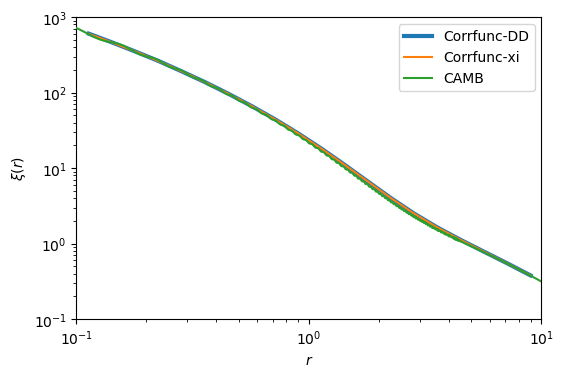

In [57]:
plt.figure(dpi = 100)
plt.plot(rx, cf, lw = 3, label = 'Corrfunc-DD')
plt.plot(rx, results_xi['xi'], label = 'Corrfunc-xi', zorder = 100)
plt.plot(r_camb, xi_camb[0], label = 'CAMB', zorder = 100)


plt.legend()
plt.loglog()
plt.xlabel(r'$r$')
plt.ylabel(r'$\xi(r)$')
plt.xlim(1e-1, 1e1)
plt.ylim(1e-1, 1e3)

#### From Nbodykit

In [73]:
def Nbodykit_result(pos, mass, Lbox, Ngrid):
    from nbodykit.lab import ArrayCatalog, FFTPower, FFTCorr  
    cat = ArrayCatalog({'Position': pos,
                       'Mass': mass})  
    mesh = cat.to_mesh(
        BoxSize=Lbox,
        Nmesh=Ngrid,
        resampler='cic',  # 'ngp', 'cic', 'tsc'
        compensated=False,    
        interlaced=False,     
        weight='Mass',
        position='Position'
    )  
    
    corr = FFTCorr(mesh, mode='1d', rmin = 0.001, rmax = 10)  
    corr.run()  
    r_kit = corr.corr['r']  
    xi_kit = corr.corr['corr']  

    return r_kit, xi_kit

In [77]:
r_kit, xi_kit = Nbodykit_result(ptpos, np.ones(len(ptpos)), 1000, 1024)

(0.1, 1000.0)

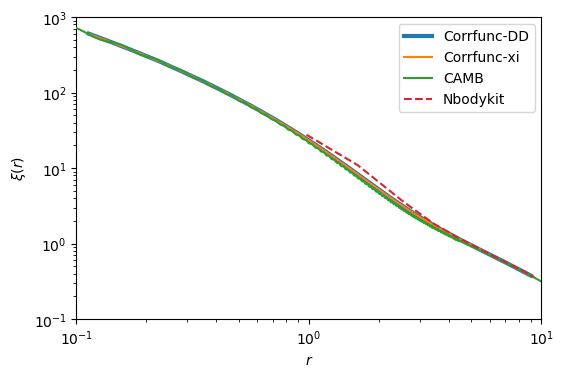

In [78]:
plt.figure(dpi = 100)
plt.plot(rx, cf, lw = 3, label = 'Corrfunc-DD')
plt.plot(rx, results_xi['xi'], label = 'Corrfunc-xi', zorder = 100)
plt.plot(r_camb, xi_camb[0], label = 'CAMB', zorder = 100)
plt.plot(r_kit, xi_kit, ls = '--', label = 'Nbodykit', zorder = 200)


plt.legend()
plt.loglog()
plt.xlabel(r'$r$')
plt.ylabel(r'$\xi(r)$')
plt.xlim(1e-1, 1e1)
plt.ylim(1e-1, 1e3)

### w(p)

We will show the projected correlation function in the simulation box

#### From Corrfunc

In [39]:
from Corrfunc.theory.DDrppi import DDrppi
from Corrfunc.utils import convert_rp_pi_counts_to_wp
def sim_rppi_corrfunc_calculation(bins, x, y, z, 
                                  rand_x, rand_y, rand_z, 
                                  nthreads=None, pimax=40, boxsize=1000):

    if nthreads is None:
        nthreads = os.cpu_count()
    
    # DD
    DD_counts = DDrppi(
        autocorr=1, nthreads=nthreads, pimax=pimax, binfile=bins,
        X1=x, Y1=y, Z1=z,
        boxsize=boxsize,
        verbose = True
    )

    # DR
    DR_counts = DDrppi(
        autocorr=0, nthreads=nthreads, pimax=pimax, binfile=bins,
        X1=x, Y1=y, Z1=z,
        X2=rand_x, Y2=rand_y, Z2=rand_z,
        boxsize=boxsize, verbose = True
    )

    # RR
    RR_counts = DDrppi(
        autocorr=1, nthreads=nthreads, pimax=pimax, binfile=bins,
        X1=rand_x, Y1=rand_y, Z1=rand_z,
        boxsize=boxsize, verbose = True
    )

    N = len(x)
    rand_N = len(rand_x)
    nrpbins = len(bins) - 1

    cf = convert_rp_pi_counts_to_wp(
        N, N, rand_N, rand_N,
        DD_counts, DR_counts, DR_counts, RR_counts,
        nrpbins, pimax
    )
    return cf

In [42]:
#run
nbins = 20
bins = np.logspace(-1, 1, nbins + 1) # note that +1 to nbins
cf_wp = sim_rppi_corrfunc_calculation(bins, xx, yy, zz, rand_X, rand_Y, rand_Z, nthreads = 32)
rx = (bins[1:] + bins[:-1])/2 

Running with points in [xmin,xmax] = 0.000000,999.999939 with periodic wrapping = 1000.000000
Running with points in [ymin,ymax] = 0.000000,999.999939 with periodic wrapping = 1000.000000
Running with points in [zmin,zmax] = 0.000000,999.999939 with periodic wrapping = 1000.000000
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 99,99,24.  Time taken =  10.772 sec
Using AVX kernel
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =    93 secs
ND1 =     23192798 [xmin,ymin,zmin] = [0.000000,0.000000,0.000000], [xmax,ymax,zmax] = [999.999939,999.999939,999.999939]
ND2 =     46385596 [xmin,ymin,zmin] = [0.000000,0.000000,0.000000], [xmax,ymax,zmax] = [1000.000000,1000.000000,999.999939]
Running with points in [xmin,xmax] = 0.000000,1000.000000 with periodic wrapping = 1000.000000
Running with points in [ymin,ymax] = 0.000000,1000.000000 with periodic wrapping = 1000.000000
Running with

In [43]:
#here direcly using corrfunc to calculate
nthreads = 18
res = wp(boxsize=1000,
         pimax=40,
         nthreads=8,
         binfile=bins,
         X=xx, Y=yy, Z=zz,
         verbose = True)

In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 100,100,25.  Time taken =   5.732 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =    66 secs


In [63]:
from scipy.interpolate import interp1d
from scipy.integrate import quad

def wp_from_camb():
    import camb
    import numpy as np
    from mcfit import P2xi
    
    from scipy.interpolate import interp1d
    from scipy.integrate import quad

    pars = camb.CAMBparams()
    pars.set_cosmology(H0=67.66, ombh2=0.02242, omch2=0.11933)
    pars.InitPower.set_params(ns=0.9665)
    pars.set_matter_power(redshifts=[0.0], kmax=100.0)
    
    #note we need to consider non-linear effect
    pars.NonLinear = camb.model.NonLinear_both
    
    results = camb.get_results(pars)
    kh, z, pk = results.get_matter_power_spectrum(
        minkh=1e-4, maxkh=300, npoints=2048
    )
    r, xi = P2xi(kh)(pk)
    xi_interp = interp1d(r, xi, bounds_error=False, fill_value=0.0)
    
    def wp_rp(rp, pimax=100):
        integrand = lambda pi: xi_interp(np.sqrt(rp**2 + pi**2))
        return 2 * quad(integrand, 0, pimax)[0]

    rp = np.logspace(-1, 1, 20+1)
    wp = np.array([wp_rp(x) for x in rp])
    return rp, wp

In [65]:
rp_camb, wp_camb = wp_from_camb()

/home/qyli/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:29: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/home/qyli/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:29: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


Text(0, 0.5, '$w_p$')

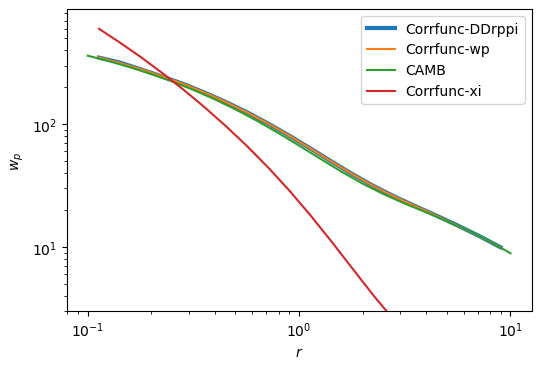

In [71]:
plt.figure(dpi = 100)
plt.plot(rx, cf_wp, lw = 3, label = 'Corrfunc-DDrppi')
plt.plot(rx, res['wp'], label = 'Corrfunc-wp', zorder = 100)
plt.plot(rp_camb, wp_camb, label = 'CAMB', zorder = 100)

plt.plot(rx, results_xi['xi'], label = 'Corrfunc-xi', zorder = 100)

plt.legend()
plt.loglog()
plt.ylim(3e0,)
plt.xlabel(r'$r$')
plt.ylabel(r'$w_p$')

## Simulation-Halo

### $\xi$(r) without mass weight

In [5]:
spnum = '127'
filepath = '/home/qyli/work2025/densityfield'
dhalo = h5py.File(filepath + '/data/sample_fof_M1000_snapshot%s_halos.hdf5'%spnum, 'r')

halo_pos = dhalo['group_pos'][0,:,:]
halo_mass = dhalo['group_mass'][0,:]

idx_ = (halo_mass > 12)      
halo_pos = halo_pos[idx_]
halo_mass = halo_mass[idx_]

In [7]:
#generate a random catalog
boxsize = 1000
xx_halo = halo_pos[:,0]
yy_halo = halo_pos[:,1]
zz_halo = halo_pos[:,2]

rand_N = len(halo_pos)*2
rand_X = np.random.uniform(0, boxsize, rand_N).astype('float32')
rand_Y = np.random.uniform(0, boxsize, rand_N).astype('float32')
rand_Z = np.random.uniform(0, boxsize, rand_N).astype('float32')
nbins = 20
bins = np.logspace(-1, 1, nbins + 1) # note that +1 to nbins

DD_counts = DD(1, 48, bins, xx_halo, yy_halo, zz_halo, periodic = False, verbose = True)
DR_counts = DD(0, 48, bins, xx_halo, yy_halo, zz_halo,
               X2=rand_X, Y2=rand_Y, Z2=rand_Z, periodic = False, verbose = True)
RR_counts = DD(1, 48, bins, rand_X, rand_Y, rand_Z,
               periodic = False, verbose = True)

N = len(xx_halo)
cf = convert_3d_counts_to_cf(
    N, N, rand_N, rand_N,
    DD_counts, DR_counts,
    DR_counts, RR_counts
)

In [11]:
xx_halo = halo_pos[:,0]
yy_halo = halo_pos[:,1]
zz_halo = halo_pos[:,2]

nbins = 20
bins = np.logspace(-1, 1, nbins + 1) # note that +1 to nbins
results_xi_halo = xi(boxsize, 48, bins, xx_halo, yy_halo, zz_halo)

(0.1, 1000.0)

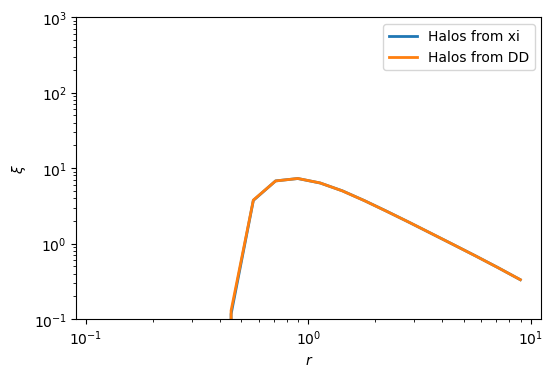

In [12]:
plt.figure(dpi = 100)
rx = (bins[1:] + bins[:-1]) / 2

plt.plot(rx, results_xi_halo['xi'], lw = 2, label = 'Halos from xi')
plt.plot(rx, cf, lw = 2, label = 'Halos from DD')
# plt.plot(rx, xi_v, lw = 2, label = 'Halos w weights (w/o Corrfunc)')
# plt.plot(rx, results_xi['xi'], label = 'DM', zorder = 100)

plt.legend()
plt.loglog()
plt.xlabel(r'$r$')
plt.ylabel(r'$\xi$')

plt.ylim(1e-1, 1e3)

###  $\xi$(r) without mass weight

In [16]:
#generate a random catalog
boxsize = 1000
xx_halo = halo_pos[:,0]
yy_halo = halo_pos[:,1]
zz_halo = halo_pos[:,2]

rand_N = len(halo_pos)*2
rand_X = np.random.uniform(0, boxsize, rand_N).astype('float32')
rand_Y = np.random.uniform(0, boxsize, rand_N).astype('float32')
rand_Z = np.random.uniform(0, boxsize, rand_N).astype('float32')
nbins = 20
bins = np.logspace(-1, 1, nbins + 1) # note that +1 to nbins

DD_counts_w = DD(1, 48, bins, xx_halo, yy_halo, zz_halo, weights1 = 10**halo_mass, weight_type = 'pair_product', periodic = False, verbose = True)
DR_counts_w = DD(0, 48, bins, xx_halo, yy_halo, zz_halo, weights1 = 10**halo_mass, weight_type = 'pair_product',
               X2=rand_X, Y2=rand_Y, Z2=rand_Z, periodic = False, verbose = True)
RR_counts_w = DD(1, 48, bins, rand_X, rand_Y, rand_Z,
               periodic = False, verbose = True)

N = len(xx_halo)
cf_weight = convert_3d_counts_to_cf(
    N, N, rand_N, rand_N,
    DD_counts_w, DR_counts_w,
    DR_counts_w, RR_counts_w
)

(0.1, 1000.0)

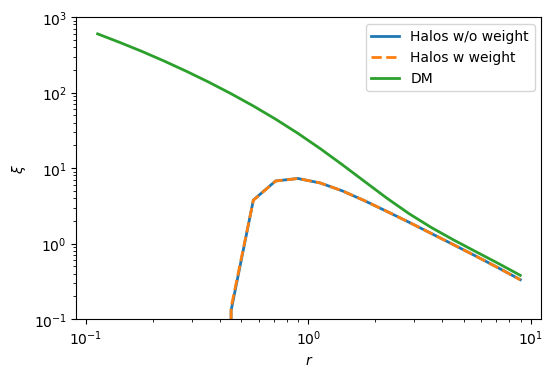

In [30]:
plt.figure(dpi = 100)
rx = (bins[1:] + bins[:-1]) / 2

plt.plot(rx, cf, lw = 2, label = 'Halos w/o weight')
plt.plot(rx, cf_weight, lw = 2, ls = '--', label = 'Halos w weight')

#=========================================================
# xi_DM = xi(1000, 36, bins, ptpos[:,0], ptpos[:,1], ptpos[:,2])
plt.plot(rx, xi_DM['xi'], lw = 2, ls = '-', label = 'DM')

plt.legend()
plt.loglog()
plt.xlabel(r'$r$')
plt.ylabel(r'$\xi$')

plt.ylim(1e-1, 1e3)

### $w_p$

In [33]:
wp_halo = wp(boxsize=1000,
         pimax=40,
         nthreads=36,
         binfile=bins,
         X=xx_halo, Y=yy_halo, Z=zz_halo,
         verbose = True)

In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 100,100,25.  Time taken =   5.069 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.144 secs


In [36]:
wp_pt = wp(boxsize=1000,
         pimax=40,
         nthreads=36,
         binfile=bins,
         X=ptpos[:,0], Y=ptpos[:,1], Z=ptpos[:,2],
         verbose = True)

In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 100,100,25.  Time taken =  11.621 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =    75 secs


(1.0, 1000.0)

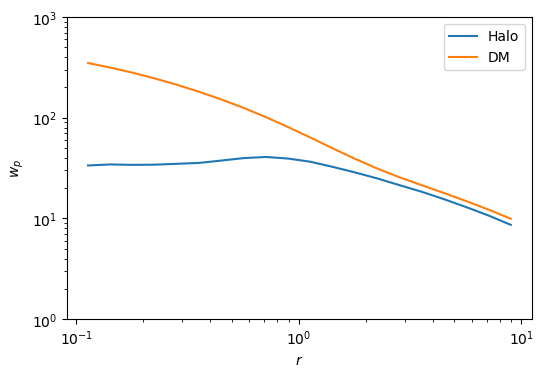

In [38]:
plt.figure(dpi = 100)
plt.plot(rx, wp_halo['wp'], label = 'Halo', zorder = 100)
plt.plot(rx, wp_pt['wp'], label = 'DM', zorder = 100)

plt.legend()
plt.loglog()
plt.xlabel(r'$r$')
plt.ylabel(r'$w_p$')

plt.ylim(1e0, 1e3)